In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile

### Setup:
  - Run `latency_test.yaml` or some other file that has short GPIOs.
  - Split audio feed so that one channel of output audio is being looped into one channel of input and the pulsing GPIO is being sent into the other input channel. 
  - You can use two 1/8" stereo-to-RCA (male) connector cables along with two RCA-RCA (f/f) connectors. 
      - One is used to connect the audio channel (left or right depending on where sounds are being generated
      - The other connects to a RCA-BNC connector, which connects to a BNC cable, which connects to a BNC-SMA connector, which can attach to the GPIO board.


### Goals:

  1. Make sure that recorded audio data looks ok
      - It was noted once that there were occasional large gaps in the recorded timestamps
  2. Figure out alignment/offsets between pulse times recorded with GPIO and pulse times recorded in audio
  3. Measure latency between GPIO and sound
  
### NOTE: The data file for this analysis used a buffer size of `64`, which corresponds to a playback buffer of 4 x 64 = 256 samples. 

In [2]:
fs, data = scipy.io.wavfile.read('../ExperimentLog2020-06-15_1834/microphone.wav')

In [3]:
audio_ts = np.loadtxt('../ExperimentLog2020-06-15_1834/microphone.wav.log', delimiter=',', skiprows=2)

### The audio timestamp file

The audio timestamp file is arranged in a Nx2 CSV array. The first value on each row is the number of samples received in the buffer, and the second value is the CLOCK_MONOTONIC timestamp retrieved immediately after the program retrieved that buffer. It is believed that that timestamp corresponds to the end of the buffer (i.e., the last sample), but the ALSA documentation is confusing.

In this example program, the buffer size was set to **B = 1024**. It is one of a 4**B**-sized ring buffer that the sound card driver writes to. So it is expected that the timestamps should be about 4**B** late relative to the code. But if we occasionally fall behind less than **B**, then it's possible that we'll see jitter. If we fall behind more than **B** but less than 3**B**, then the driver should return a larger buffer which we would record. If we fall behind longer, then there was an overrun, which should have been seen on the screen.

So first, let's check to see if any buffer sizes are different than expected.

In [4]:
buffer_sizes = np.unique(audio_ts[:,0])
print(buffer_sizes)

[1024.]


In our example, we only see one value.

**B = 1024** should correspond to a delay of about 1024/48000 (the sampling rate for this file). So next, let's check for excessive differences in the timestamps.

In [5]:
diff_ts = np.diff(audio_ts[:,1]/1e9) # convert timestamps to seconds (from ns) and take a diff
np.where(diff_ts > (buffer_sizes[0]/fs)*1.2)

(array([], dtype=int64),)

In our example, we didn't find any values more than 1.2 times the expected buffer size. Let's look at a histogram just to be fun.

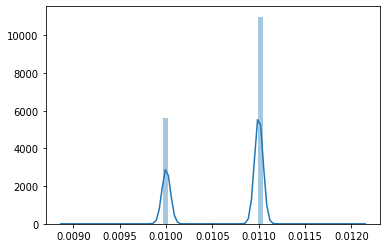

In [6]:
import seaborn as sns
sns.distplot(diff_ts)

I'm not sure what the two peaks mean. 

In order to get timestamps for each sample, let's regress our data!

Measured slope: {}. Expected (1/FS): {} 1.0414321108152863e-05 1.0416666666666666e-05
Time for (N-B) samples:  1256.3464967749997
Print N-B is:  120636416.0
Approximate FS is:  96021.6121186868


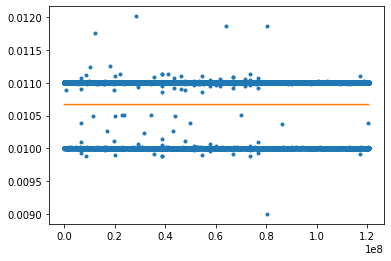

In [7]:
import scipy.stats

n_buffer = np.cumsum(audio_ts[:,0])
buffer_ts = audio_ts[:,1]/1e9

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(n_buffer,buffer_ts)

print('Measured slope: {}. Expected (1/FS): {}', slope, 1/fs)

plt.plot(n_buffer[:-1],np.diff(audio_ts[:,1])/1e9,'.')
plt.plot(n_buffer[:-1],np.ones(n_buffer.shape[0]-1)*buffer_sizes[0]/fs)

print('Time for (N-B) samples: ', (buffer_ts[-1]-buffer_ts[0]))
print('Print N-B is: ', n_buffer[-1]-n_buffer[0])
print('Approximate FS is: ', (n_buffer[-1]-n_buffer[0])/(buffer_ts[-1]-buffer_ts[0]))

### Look at some data
Next, let's look at our data. In this example file, the tones are on channel 1 and the pulses are on channel 0.

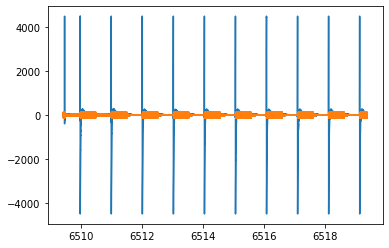

In [8]:
t_sound = intercept + np.arange(0, data.shape[0], step=1) * slope
plt.plot(t_sound[:96000*10], data[:96000*10,:]);


### Let's find the pulse times. 

Here `nelpy` can help us alot, namely `get_threshold_crossing_epochs`, which will give us our pulse times! What to use for threshold?

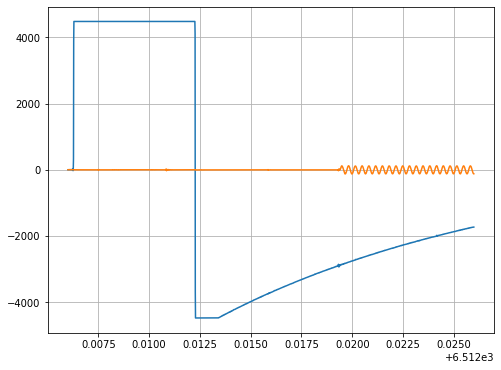

In [28]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
idx = np.argmin(np.abs(t_sound-6512.006))
ax.plot(t_sound[idx:(idx+960*2)], data[idx:(idx+960*2),:]);
ax.grid()
#plt.gca().set_ylim(0,100)

In [9]:
import nelpy as nel

/home/ckemere/Code/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [29]:
audio_pulses_nel = nel.AnalogSignalArray(data[:,0], time=t_sound, fs=96000)

In [30]:
import time
t0 = time.time()
audio_pulse_epochs = nel.utils.get_threshold_crossing_epochs(audio_pulses_nel, t1=3000, t2 = 20)
t1 = time.time()
print('Finding pulses took {}s'.format(t1-t0))

Finding pulses took 40.119065284729004s


In [31]:
audio_pulse_epochs.data[:,0] # Here they are!

array([6509.45826498, 6509.96625473, 6510.98625417, ..., 7763.55110442,
       7764.57112469, 7765.59112413])

### GPIO Data

Next, let's load the GPIO data. It's also stored in a CSV file. Each row corresponds to a record with
  1. The master time (from the clock on the IO board) - these should increment exactly 2 ms each sample
  2. GPIO - an Int corresonding to the values of each of the pins
  3. Encoder - the value of the rotational encoder. For our situation, the encoder usually goes from 0 to 4095
  4. UnwrappedEncoder - the unwrapped value of the encoder - this increments all the way to the maximum value (32 bit)
  5. last_ts - the CLOCK_MONOTONIC value (converted to seconds) received at the sampling time

In [32]:
gpio_data = np.loadtxt('../ExperimentLog2020-06-15_1834/DataLog.csv', delimiter=',', skiprows=2)

Next, let's look at the pulses as recorded by the GPIO

In [91]:
gpio_pulse_train_data = gpio_data[:,1].astype(int) & 1 # Our pulse pin is channel 0 (0x0001)
gpio_response_train_data = gpio_data[:,1].astype(int) & 4 # Our pulse pin is channel 0 (0x0001)

Again, we'll use `nelpy.utils.get_threshold_crossing_epochs` to find them. We'll use the `CLOCK_MONOTONIC` timestamps rather than the 1 kHz Master Clock so that we can match them up to the audio.

In [94]:
gpio_pulses_nel = nel.AnalogSignalArray(gpio_pulse_train_data.astype(float), time=gpio_data[:,-1])
gpio_pulse_epochs = nel.utils.get_threshold_crossing_epochs(gpio_pulses_nel, t1=0.5)

gpio_responses_nel = nel.AnalogSignalArray(gpio_response_train_data.astype(float), time=gpio_data[:,-1])

Do we find the same number as in the audio recorded file?

In [35]:
print('Number of pulses recorded in audio file: {}; gpio file: {}'.format(len(audio_pulse_epochs), len(gpio_pulse_epochs)))

Number of pulses recorded in audio file: 1233; gpio file: 1232


In [42]:
print(gpio_pulse_epochs[:5].data)
print(audio_pulse_epochs[:5].data)

[[6509.96721536 6509.97321685]
 [6510.98722092 6510.9932428 ]
 [6512.00723898 6512.01324229]
 [6513.02722752 6513.03322937]
 [6514.04724082 6514.05323125]]
[[6509.45826498 6509.45869197]
 [6509.96625473 6509.97224297]
 [6510.98625417 6510.99228406]
 [6512.00626402 6512.01227309]
 [6513.02626346 6513.0322517 ]]


And how do the `CLOCK_MONOTONIC` timestamps compare in GPIO and wav-file-log records?

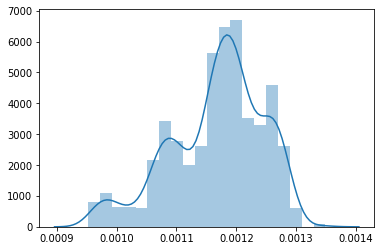

In [76]:
sns.distplot(gpio_pulse_epochs.data[:,0] - audio_pulse_epochs.data[1:,0]) # the epochs hold the start (index 0) and stop of pulses

Pretty good. Using the linear interpolation approach to find the audio timestamps, 
it appears that we end up with a consistent difference of almost 1 ms between the data
recorded using the GPIO/serial interface and the logging of the microphone data.
Specifically, the GPIO data is about 1 ms later than the signal recorded in the
wav file. This may be reasonable - the pulse is triggered, but then doesn't
get *reported* (and thus `CLOCK_MONOTONIC` sampled until the next sample. But
that should actually be **2** ms later (because the GPIO samples come every 2 ms)! 
So that suggets that **our audio timestamps are actually about _1 ms delayed_ 
from their proper real-time value.** 

**BUT WAIT** -
### Next, let's actually look at the latency of the sine wave versus the GPIO pulse.

In [45]:
audio_tone_nel = nel.AnalogSignalArray(data[:,1], time=t_sound, fs=96000)

Text(0.5, 0, 'Time (s)')

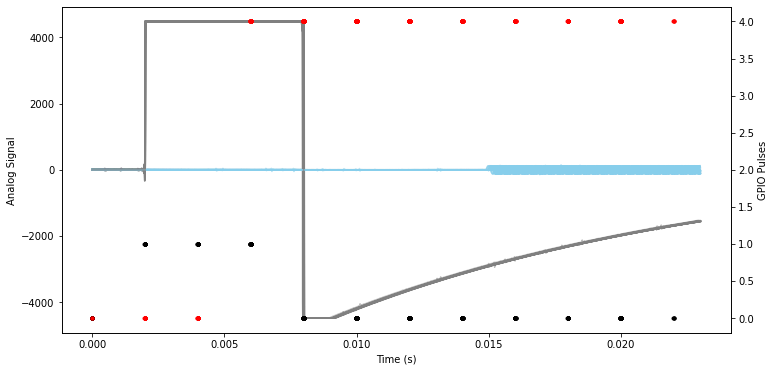

In [95]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax2 = ax.twinx()
for ep in audio_pulse_epochs[2:1000:20]:
    t = audio_tone_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].abscissa_vals
    d1 = audio_tone_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].data
    d2 = audio_pulses_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].data
    g1 = gpio_pulses_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].data
    tg1 = gpio_pulses_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].abscissa_vals
    r1 = gpio_responses_nel[ep.expand(0.002, direction='start').expand(0.015, direction='stop')].data

    ax.plot(t - t[0], d1.T, color='skyblue', alpha=0.5)
    ax.plot(t - t[0], d2.T, color='gray', alpha=0.5)
    ax2.plot(tg1 - tg1[0], g1.T, 'k.')
    ax2.plot(tg1 - tg1[0], r1.T, 'r.')
    
ax2.set_ylabel('GPIO Pulses')
ax.set_ylabel('Analog Signal')
ax.set_xlabel('Time (s)')

We see from the above figure that the latency may actually come from something about the way that the threshold crossing algorithm is being implemented for the GPIOs. The actual time of the GPIO pulse being high is quite well aligned (sub-millisecond) with the pulse from the analog input.

The `latency_test.yaml` state machine is structured as follows: `RaiseGPIO` sets the pulse GPIO high with a conditional transition on the sense pin is detected high; `SignalGPIO` raises a second GPIO; `LowerPulse` lowers the pulse GPIO pin; `PlaySound` plays the sine wave. We can see that the time between when the GPIO is raised and lowered is 8 ms, which matches expectations (GPIO goes high, the next 2 ms tick it's detected (and a state transition is triggered), the next tick the `Signal` GPIO is raised, and the next tick it's lowered).

Also, we see that the time from the initial trigger pulse to the sine wave onset is about 13 ms. The sound transition is triggered after the GPIO is lowered, or 8 ms after the pulse went high. 6 ms of that 8 ms is just due to state machine transitions, so the "real" **closed-loop latency** - *the time between when an IO state change is detected and a change in sound is measurable on the sound card output* -  is about **7 ms**.
